In [1]:
import os
import pickle
from itertools import product
from tqdm import tqdm

import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import arch

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, f1_score, accuracy_score

import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
from IPython import display

# for ignoring warnings while fitting ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# modified sklearn time series k-fold groupped splitter with additional gap parameter
# motivated by https://www.kaggle.com/jorijnsmit/found-the-holy-grail-grouptimeseriessplit
from splitting import PurgedGroupTimeSeriesSplit, plot_cv_indices

In [3]:
class DataLoader:
    '''The following class will be used to load the data and apply few initial filtering/preprocessing steps'''
    @classmethod
    def load(cls, asset: str,
             sampling: str = '1H',
             feature_sampling: int = 6,
             year_start: int = 2000,
             year_end: int = None):
        if os.path.exists(f'{asset}.csv'):
            data = pd.read_csv(f'{asset}.csv', header=None)
        else:
            raise FileNotFoundError('{asset}.csv was not found!')
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
        data.iloc[:, 1:-1] /= 10e3
        data['Date'] = pd.to_datetime(data['Date'])
        if year_end is None:
            year_end = data['Date'].dt.year.unique()[-1]
        data = data[(data['Date'].dt.year >= year_start) & (data['Date'].dt.year <= year_end)]
        data.reset_index(inplace=True, drop=True)
        if sampling != '1H':
            data = cls._resample(data, sampling)
        data = cls.featurise(data, s=feature_sampling)
        # for each observation t add t+1 binary target
        data['target'] = np.sign(data['ln_Close'].shift(-1))
        # dropna from the last row
        data.dropna(inplace=True)
        # due to the nature of our data (only 2 decimal points) there are few occasions when close price is unchanged
        # applying a small tweak to make our target and prediction binary since there are only few such values
        data.loc[data['target'] == 0, 'target'] = 1
        return data

    @staticmethod
    def _resample(data: pd.DataFrame, sampling):
        data.set_index('Date', inplace=True)
        data = data.resample(sampling).agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last'})
        data.dropna(inplace=True)
        data.reset_index(inplace=True)
        return data
    
    @staticmethod
    def featurise(data: pd.DataFrame, s: int):
        '''
            method to add additional features to the dataset
            s: int, sampling window (i.e. how many hourly observations per session)
        '''
        # add log returns for the Close prices
        data['ln_Close'] = np.log(data['Close'] / data['Close'].shift(1))
        
        # simple ratios/diffs
        data['shadow_up'] = data['High'] - np.maximum(data['Close'], data['Open'])
        data['sahdow_down'] = np.minimum(data['Close'], data['Open']) - data['Low']
        data["hl_ratio"] = data['High'] / data['Low']
        data["oc_diff"] = data['Open'] - data['Close']
        
        # Moving averages - 20, 50, 100, 200 sessions (adjusted by the sampling)
        data['MA20'] = data['Close'].rolling(window=20*s).mean()
        data['MA50'] = data['Close'].rolling(window=50*s).mean()
        data['MA100'] = data['Close'].rolling(window=100*s).mean()
        data['MA200'] = data['Close'].rolling(window=200*s).mean()
        
        # Exponential weighted moving averages - 8, 20 sessions
        data['EWMA8'] = data['Close'].ewm(span=8*s, min_periods=8*s, adjust=False).mean()
        data['EWMA20'] = data['Close'].ewm(span=20*s, min_periods=20*s, adjust=False).mean()
        # Moving average convergence/divergence
        data['MACD'] = data['EWMA20'] - data['EWMA8']

        # Bollinger Bands - 20 sessions, 2 std dev
        data['MA20_std'] = data['Close'].rolling(window=20*s).std()
        data['BB_high'] = data['MA20'] + 2 * data['MA20_std']
        data['BB_low'] = data['MA20'] - 2 * data['MA20_std']
        data.drop(['MA20_std'], axis=1, inplace=True)

        # RSI
        delta = data['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=14*s, min_periods=14*s, adjust=False).mean()
        ema_down = down.ewm(com=14*s, min_periods=14*s, adjust=False).mean()
        rs = ema_up/ema_down
        rs = ema_up/ema_down
        data['RSI'] = 100 - (100/(1 + rs))
        del delta, up, down, ema_up, ema_down, rs
        
        # realised volatility - 8, 20 sessions (https://www.realvol.com/VolFormula.htm)
        rvol = lambda x: np.sqrt(np.sum(x**2) * 252/(s*len(x))) * 100
        data['VOL8'] = data['ln_Close'].rolling(8).apply(rvol)
        data['VOL20'] = data['ln_Close'].rolling(20).apply(rvol)
        
        data.dropna(inplace=True)
        
        return data

Loading hourly IBM stock data since 2000, which is then resampled into 3 hour candles. The data is sourced from https://github.com/QuantConnect/Lean/tree/master/Data/equity which was provided by QuantQuote.

In [4]:
df = DataLoader.load('ibm', sampling='3H', feature_sampling=3, year_start=2000)
df.head()

,Date,Open,High,Low,Close,ln_Close,shadow_up,sahdow_down,hl_ratio,oc_diff,...,MA200,EWMA8,EWMA20,MACD,BB_high,BB_low,RSI,VOL8,VOL20,target
599,2000-10-17 09:00:00,111.94,113.44,108.88,109.00,-0.017642,1.50,0.12,1.041881,2.94,...,114.629300,111.626631,115.405711,3.779080,127.286574,105.024759,43.797574,21.981533,20.188468,1.0
600,2000-10-17 12:00:00,109.00,112.50,108.56,111.00,0.018182,1.50,0.44,1.036293,-2.00,...,114.624717,111.576501,115.261262,3.684761,126.907002,104.947998,45.498505,17.367173,20.452316,1.0
601,2000-10-17 15:00:00,111.00,113.88,109.00,113.00,0.017858,0.88,2.00,1.044771,-2.00,...,114.623367,111.690381,115.187122,3.496741,126.454947,104.993720,47.136478,11.176799,20.719559,-1.0
602,2000-10-18 09:00:00,96.75,99.13,90.25,96.50,-0.157845,2.38,6.25,1.098393,0.25,...,114.591800,110.475150,114.574429,4.099279,126.837604,103.677729,37.593494,52.342260,37.955491,-1.0
603,2000-10-18 12:00:00,96.63,97.63,90.25,94.94,-0.016298,1.00,4.69,1.081773,1.69,...,114.560867,109.232338,113.930678,4.698340,127.182065,102.326935,36.870939,52.591791,38.098372,1.0


Backtester was meant to be built to imitate the real-life trading, meaning that we have a sliding window where we fit our strategy and make one step ahead prediction. Therefore we iterate over our data using the window to avoid any forward looking bias. Refit window is used to reduce the time of backtesting as optimizing ARIMA `(p,d,q)` parameters on each step is very time expensive, therefore we will only do it once in a while and use these stored parameters until the next refit time comes.

In [30]:
class BackTester:
    def __init__(self, 
                 data: pd.DataFrame, 
                 strategy,
                 window: int, 
                 refit_window: int):
        '''
            data: data for backtesting
            strategy: strategy class to backtest
            window: time window on which to fit the strategy
            refit_window: how often we refit the strategy
        '''
        self.data = data
        self.strategy = strategy
        self.window, self.refit_window = window, refit_window
    
    def run(self):
        '''main method to iterate over the data and store predictions'''
        # in this way t+1 prediction will be stored in the same row as t+1 observation making it convenient to calculate Pnl
        predictions = [np.nan] * self.window
        for i, idx in enumerate(tqdm(range(self.data.shape[0] - self.window))):
            # slice the window
            X = self.data.iloc[idx:idx + self.window, :]
            # check if it is time to refit
            if i % self.refit_window == 0:
                self.strategy.fit(X)
            # make one step prediction
            pred = self.strategy.predict(X)
            predictions.append(pred)

        self.data['Pred'] = predictions
        
        # cache results
        with open(f'{self.strategy.__class__.__name__}_{self.window}_{self.refit_window}.pkl', 'wb') as f:
            pickle.dump(self.data, f)
        print(f'{self.strategy.__class__.__name__}_{self.window}_{self.refit_window}.pkl is cached.')
            
    def plot_pnl(self, is_binary_prediction: bool, cache_path=None):
        if cache_path is not None:
            with open(cache_path, 'rb') as f:
                self.data = pickle.load(f)
        # get rid of nans
        data = self.data.copy().dropna()
        
        if not is_binary_prediction:
            # transform the predictions from the log changes to the binary format by taking the sign
            data['Pred'] = np.sign(data['Pred'])
        
        plt.figure(figsize=(10, 8))
        # plot buy&hold benchmark
        plt.plot(data['Date'], data['Close'].diff().cumsum(), c='red', label='Buy&Hold')
        plt.plot(data['Date'], data['Close'].diff().mul(data['Pred']).cumsum(), c='C0', label=self.strategy.__class__.__name__)
        plt.grid()
        plt.legend()
        plt.title('PnL results')
        plt.show()
        
        # run some metrics
        y_pred = data['Pred']
        y_true = np.sign(data['ln_Close'])
        # due to the nature of our data (only 2 decimal points) there are few occasions when close price is unchanged
        # applying a small tweak to make our target and prediction binary
        y_true[y_true == 0] = 1.0
        y_pred[y_pred == 0] = 1.0
        print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
        print(f'f1: {f1_score(y_true, y_pred)}')

In [29]:
class BaseStrategy:
    '''Abstract strategy class to implement fit and predict methods'''
    def fit(self, X):
        raise NotImplementedError
    
    def predict(self, X=None):
        raise NotImplementedError

class StrategyDummy(BaseStrategy):
    '''Dummy strategy which is just using the last value as a prediction'''
    def fit(self, X):
        pass
    
    def predict(self, X=None):
        return X['ln_Close'].values[-1]

class StrategyARIMA(BaseStrategy):
    '''ARIMA strategy class'''
    def __init__(self, max_p: int = 5, max_q: int = 5):
        super().__init__()
        self.max_p, self.max_q = max_p, max_q
        self.params = None
    
    def fit(self, X):
        '''Calculates ARIMA parameters by minimizing Akaike Information Criterion and stores the best combination'''
        xs = X['ln_Close'].values
        final_aic = np.inf
        parameters = list(product(range(5), range(5)))
        for param in parameters:
            if param[0] == param[1] == 0:
                continue
            try:
                model = ARIMA(xs, order=(param[0], 0, param[1])).fit()
            except ValueError:
                continue
            if model.aic < final_aic:
                final_aic = model.aic
                self.params = param
        
    def predict(self, X=None):
        '''Predicts the next value by fitting the ARIMA model to the latest available data
            with the set of the stored parameters'''
        xs = X['ln_Close'].values
        model = ARIMA(xs, order=(self.params[0], 0, self.params[1])).fit()
        pred = model.forecast(steps=1)[0]
        return pred
    
class StrategyARIMAGARCH(BaseStrategy):
    '''ARIMA+GARCH strategy class'''
    def __init__(self, max_p: int = 5, max_q: int = 5):
        super().__init__()
        self.max_p, self.max_q = max_p, max_q
        self.params = None
    
    def fit(self, X):
        '''
            Calculates ARIMA parameters by minimizing Akaike Information Criterion and stores the best combination.
        '''
        xs = X['ln_Close'].values
        final_aic = np.inf
        parameters = list(product(range(5), range(5)))
        for param in parameters:
            if param[0] == param[1] == 0:
                continue
            try:
                model = ARIMA(xs, order=(param[0], 0, param[1])).fit()
            except ValueError:
                continue
            if model.aic < final_aic:
                final_aic = model.aic
                self.params = param
                
    def predict(self, X=None):
        '''
            To predict the next value we first fit ARIMA with optimised set of parameters.
            Then we fit GARCH using ARIMA's residuals and combine the prediction of ARIMA+GARCH models.
        '''
        xs = X['ln_Close'].values
        arima = ARIMA(xs, order=(self.params[0], 0, self.params[1])).fit()
        arima_pred = arima.forecast(steps=1)[0]
        
        garch = arch.arch_model(arima.resid)
        garch_fit = garch.fit(disp='off', show_warning=False)
        garch_pred = garch_fit.forecast(horizon=1).mean.iloc[-1]['h.1']
        
        pred = arima_pred + garch_pred
        
        return pred

Let's first check if our BackTester class works correctly using the simple Dummy Strategy.

In [31]:
strategy = StrategyDummy()

backtester = BackTester(data=df,
                       strategy=strategy,
                       window=3*252*2,
                       refit_window=3*252)
backtester.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 13876/13876 [00:02<00:00, 5274.51it/s]

StrategyDummy_1512_756.pkl is cached.


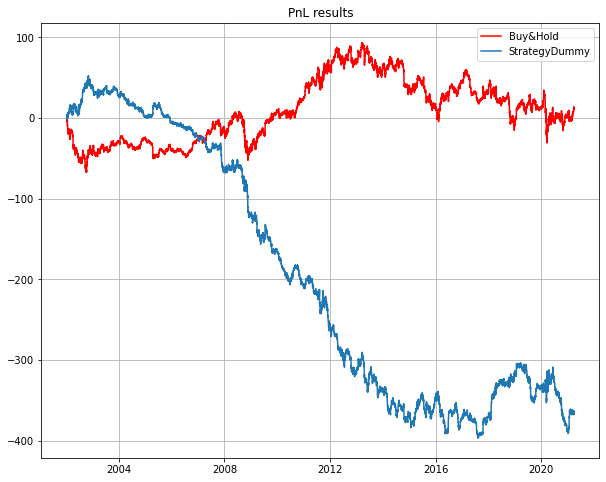

Accuracy: 0.4862512090645295
f1: 0.48942598187311176


In [36]:
backtester.plot_pnl(is_binary_prediction=False)

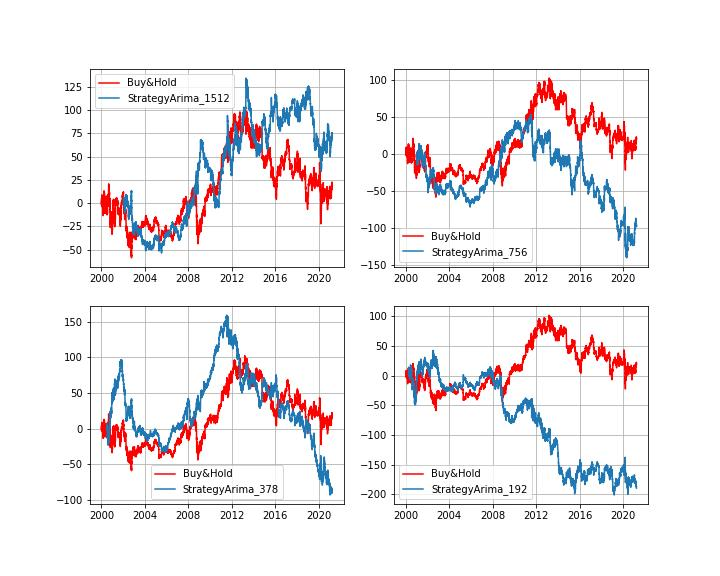

In [29]:
display.Image('ARIMAs_PnL.jpg')

In [46]:
strategy = StrategyARIMAGARCH()

backtester = BackTester(data=df,
                       strategy=strategy,
                       window=3*252*2,
                       refit_window=3*252)
backtester.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 14474/14474 [1:42:08<00:00,  2.36it/s]

StrategyARIMAGARCH_1512_756.pkl is cached.


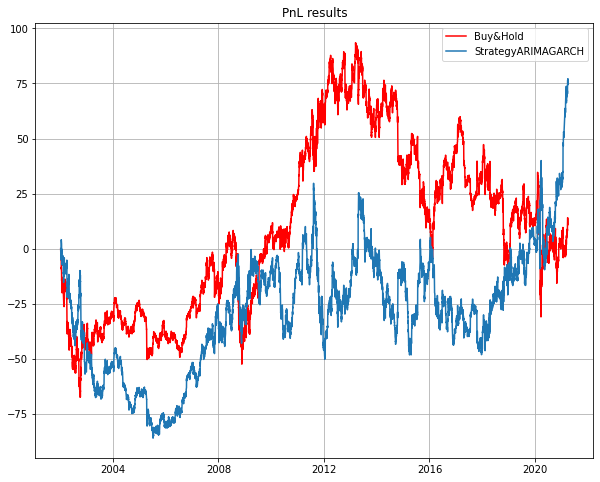

Accuracy: 0.49799640735111234
f1: 0.5347675758739916


In [48]:
backtester.plot_pnl(is_binary_prediction=False, cache_path='StrategyARIMAGARCH_1512_756.pkl')

### Introducing ML trading strategies

In [5]:
from sklearn.model_selection import train_test_split 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, shuffle=False)

In [7]:
groups = pd.factorize(X_train['Date'].dt.day.astype(str) + '_' + \
                      X_train['Date'].dt.month.astype(str) + '_' + \
                      X_train['Date'].dt.year.astype(str))[0]

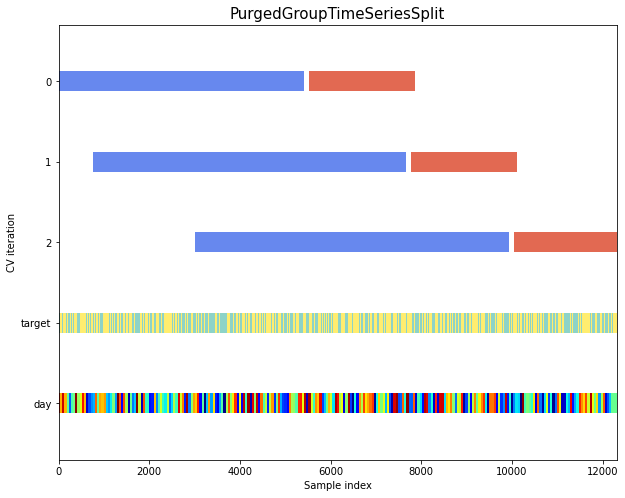

In [8]:
fig, ax = plt.subplots(figsize =(10, 8))
cv = PurgedGroupTimeSeriesSplit(n_splits=3, group_gap=20*3, max_train_group_size=252*3*3, 
                                max_test_group_size=252*3)
plot_cv_indices(cv, X_train, y_train, groups, ax, 3, lw=20)
plt.show()

In [40]:
y_train.value_counts()

 1.0    6106
-1.0    6092
 0.0     111
Name: target, dtype: int64

In [9]:
import optuna.integration.lightgbm as lgb
import optuna

In [28]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        'seed': 42,
        'verbosity': -1,
        'boosting_type': 'gbdt',
        "feature_pre_filter": False
    }

    lgbcv = lgb.cv(param,
                   dtrain,
                   folds=cv.split(X=X_train, y=y_train, groups=groups),
                   verbose_eval=False,                   
                   early_stopping_rounds=250,                   
                   num_boost_round=10000,                    
                   callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ]
                  )

    cv_score = lgbcv['binary_error-mean'][-1] + lgbcv['binary_error-stdv'][-1]
    
    return cv_score

In [29]:
dtrain = lgb.Dataset(X_train.drop('Date', axis=1), label=y_train)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=10800)

In [30]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 1340
Best trial: {'lambda_l1': 0.011125666476802836, 'lambda_l2': 0.5937301133842666, 'num_leaves': 345, 'feature_fraction': 0.5283122648125629, 'bagging_fraction': 0.8297292011133033, 'bagging_freq': 15, 'min_child_samples': 3}


In [31]:
import json

In [32]:
with open('lgbm_param.json', 'w') as f:
    json.dump(study.best_trial.params, f)